In [1]:
# turn off pink warning boxes
import warnings
warnings.filterwarnings("ignore")

# visualize 
import matplotlib.pyplot as plt
# for tsa
import statsmodels.api as sm
import itertools as it

from fbprophet import Prophet

#important import 
import pandas as pd
import numpy as np
import os
import wrangle as w
import model as m

Importing plotly failed. Interactive plots will not work.


In [2]:
# plotting defaults
plt.rc('figure', figsize=(13, 7))
plt.style.use('seaborn-dark-palette')
plt.rc('font', size=16)

In [3]:
#Acquire superstore data from codeup database
df = w.get_superstore_data()

In [4]:
#Cleaning superstore data
df = w.prep_superstore(df, 'Order Date', 'Ship Date')

In [5]:
#Does one or another stand out in terms of sales volume? 

In [6]:
#What does sales look like over time?

<AxesSubplot:xlabel='Order Date'>

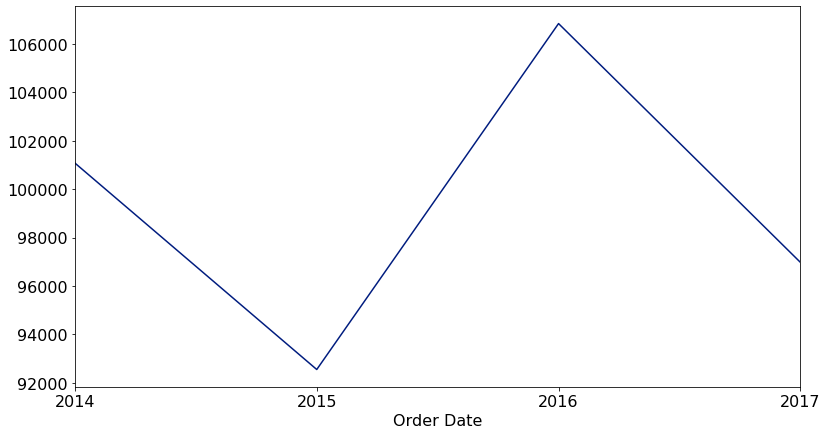

In [7]:
#Look at the total sales over the years
df.resample('Y').sales.sum().plot()

<AxesSubplot:xlabel='Order Date'>

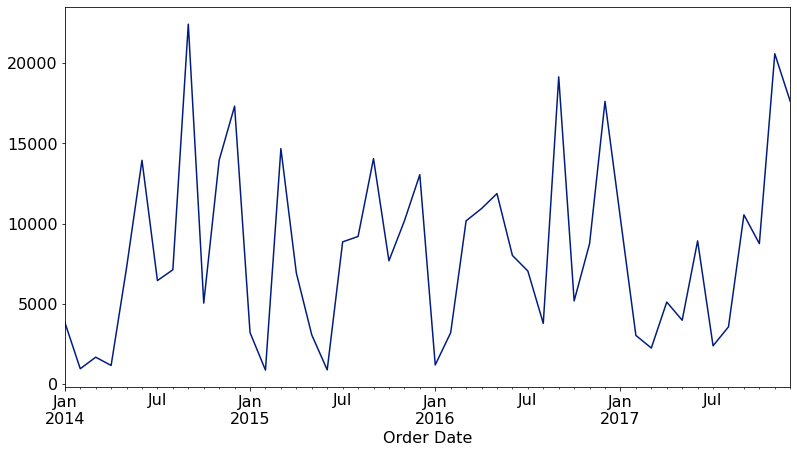

In [8]:
#Look at the total sales for every month
df.resample('M').sales.sum().plot()

In [9]:
#Split data
train, validate, test = w.split_time_series_data(df)

Text(0, 0.5, 'Total Sales')

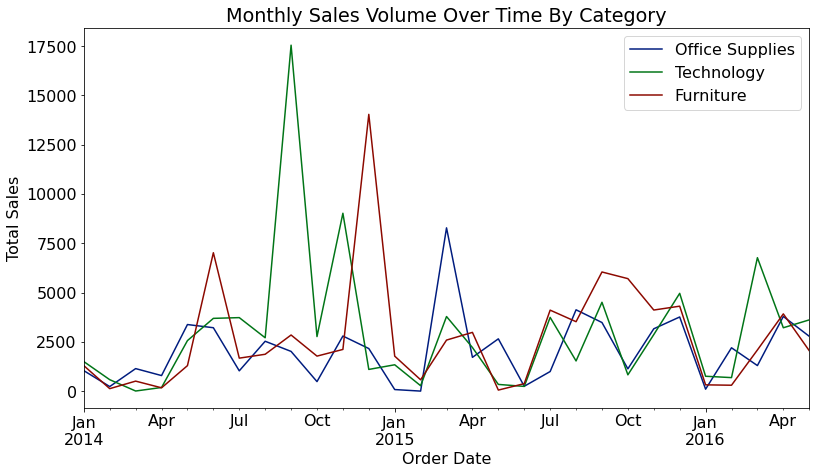

In [10]:
#Better graph
for c in train.category.unique():
    sample = train[train.category == c]
    sample.resample('M').sales.sum().plot(label=c)
    plt.legend()
plt.title("Monthly Sales Volume Over Time By Category")
plt.ylabel("Total Sales")

Text(0, 0.5, 'Total Sales')

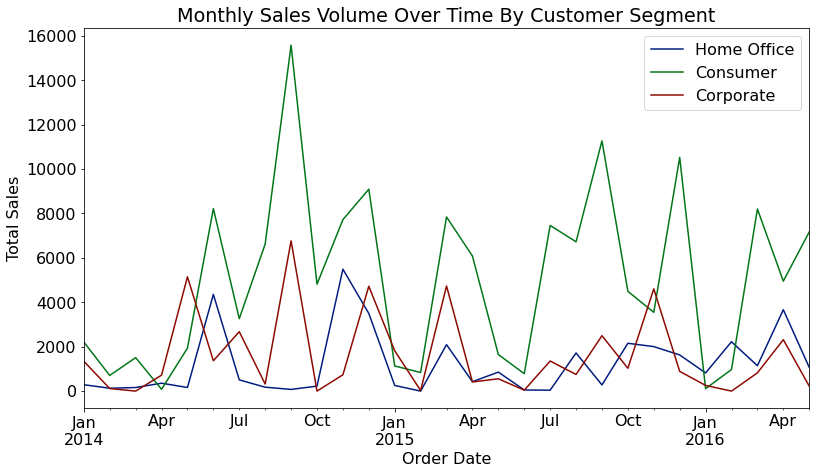

In [11]:
for s in train.segment.unique():
    sample = train[train.segment == s]
    sample.resample('M').sales.sum().plot(label=s)
    plt.legend()
plt.title("Monthly Sales Volume Over Time By Customer Segment")
plt.ylabel("Total Sales")

ValueError: zero-size array to reduction operation fmin which has no identity

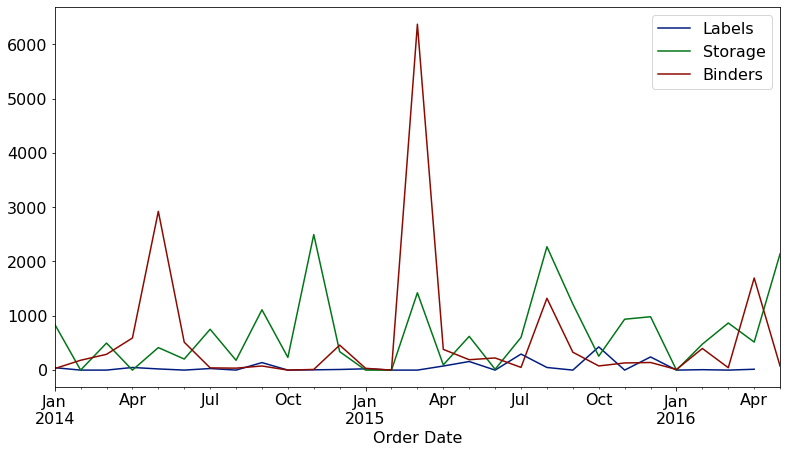

In [12]:
# Plot sales volume by category - different plot for each segment
for s in train.category.unique():
    for c in train.sub_category.unique():
        sample = train[(train.sub_category == c)&(train.category == s)]
        sample.resample('M').sales.sum().plot(label=c)
        plt.legend()
    plt.title(f"Monthly Sales Volume By Category - {s}")
    plt.ylabel("Total Sales")
    plt.show()

In [ ]:
#What our average sales look like for each month?
train['month'] = pd.Categorical(train['month'], categories=['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August',
                                                            'September','October', 'November', 'December'])
overall_mean = train.groupby('month').sales.mean().mean()
train.groupby('month').sales.mean().plot.bar()
plt.title("Average Sales by Month")
plt.xlabel("Months")
plt.ylabel("Sales")
plt.tick_params('x', rotation=65)
plt.axhline(overall_mean,color="r")

In [ ]:
# Using decomposition that allows us to decompose our time series into three distinct components: trend, seasonality, and noise.
y = train.resample('M').sales.sum()
sm.tsa.seasonal_decompose(y).plot()
None

#### Overall takeaway:

We observe that sales of furniture and office supplies shared a similar seasonal pattern. Early of the year is the off season for both of the two categories. In addition, average daily sales for furniture are higher than those of office supplies in most of the months. It is understandable, as the value of furniture should be much higher than those of office supplies. Occasionally, office supplies passed furniture on average daily sales. Technology is high across all 3 segments

In [ ]:
#auto correlation
pd.plotting.autocorrelation_plot(train.sales.resample('M').mean())

Easier to tell trends when sampled over longer period of time

In [ ]:
#Modeling
#We will prophet for model because
#Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. 
#It works best with time series that have strong seasonal effects and several seasons of historical data. 
#Prophet is robust to missing data and shifts in the trend, and typically handles outliers well.

In [ ]:
#Segments and Category
for s in train.segment.unique():
    for c in train.category.unique():
        sample = train[(train.category == c)&(train.segment == s)]

In [ ]:
#Extract the data of Office Supplies, technology and furniture
office_supplies = train.loc[train['category'] == 'Office Supplies']
furniture = train.loc[train['category'] == 'Furniture']


In [15]:
test =df['2016':'2017']

In [17]:
technology = test.loc[test['category'] == 'Technology']

In [18]:
technology

,ship_date,ship_mode,segment,country,city,state,postal_code,sales,quantity,discount,profit,customer_name,product_name,category,sub_category,region_name,month,year
Order Date,,,,,,,,,,,,,,,,,,
2016-01-05,2016-01-07,Second Class,Corporate,United States,Jacksonville,Florida,32216.0,191.472,6.0,0.2,40.6878,Anthony Johnson,Logitech MX Performance Wireless Mouse,Technology,Accessories,South,January,2016
2016-01-05,2016-01-07,Second Class,Corporate,United States,Jacksonville,Florida,32216.0,59.184,2.0,0.2,5.1786,Anthony Johnson,Logitech B530 USB Headset - headset - Full siz...,Technology,Phones,South,January,2016
2016-01-11,2016-01-13,Second Class,Home Office,United States,Springfield,Ohio,45503.0,15.588,2.0,0.4,-9.8724,Deanra Eno,Cyber Acoustics AC-202b Speech Recognition Ste...,Technology,Phones,East,January,2016
2016-01-16,2016-01-20,Second Class,Consumer,United States,Los Angeles,California,90049.0,90.570,3.0,0.0,11.7741,Eric Hoffmann,Imation 8GB Mini TravelDrive USB 2.0 Flash Drive,Technology,Accessories,West,January,2016
2016-01-17,2016-01-21,Standard Class,Home Office,United States,Concord,New Hampshire,3301.0,29.990,1.0,0.0,13.1956,Chuck Clark,Logitech 910-002974 M325 Wireless Mouse for We...,Technology,Accessories,East,January,2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-10,2017-12-14,Standard Class,Consumer,United States,Philadelphia,Pennsylvania,19120.0,14.200,1.0,0.2,3.3725,Helen Andreada,Memorex Froggy Flash Drive 8 GB,Technology,Accessories,East,December,2017
2017-12-11,2017-12-15,Standard Class,Consumer,United States,New York City,New York,10009.0,39.980,2.0,0.0,13.5932,Mike Vittorini,Logitech LS21 Speaker System - PC Multimedia -...,Technology,Accessories,East,December,2017
2017-12-18,2017-12-23,Second Class,Consumer,United States,Encinitas,California,92024.0,119.980,2.0,0.0,57.5904,Russell Applegate,Logitech Illuminated - Keyboard,Technology,Accessories,West,December,2017


In [ ]:
office_supplies = office_supplies[['sales']]
furniture = furniture[['sales']]

In [19]:
technology = technology[['sales','profit']]

In [ ]:
office_supplies = office_supplies.sort_values('Order Date')
office_supplies = office_supplies.groupby('Order Date')['sales'].sum().reset_index()
office_supplies = office_supplies.set_index('Order Date')
office_supplies.head()

In [ ]:
furniture = furniture.sort_values('Order Date')
furniture = furniture.groupby('Order Date')['sales'].sum().reset_index()
furniture = furniture.set_index('Order Date')
furniture.head()

In [20]:
technology = technology.sort_values('Order Date')
technology = technology.groupby('Order Date')['sales','profit'].sum().reset_index()
technology = technology.set_index('Order Date')
technology.head()

,sales,profit
Order Date,,
2016-01-05,250.656,45.8664
2016-01-11,15.588,-9.8724
2016-01-16,90.570,11.7741
2016-01-17,401.960,80.1502
2016-02-05,589.680,154.3653


In [ ]:
monthly_office = office_supplies['sales'].resample('M').mean()
monthly_furniture = furniture['sales'].resample('M').mean()

In [21]:
monthly_technology_sales = technology['sales'].resample('M').mean()

In [22]:
monthly_technology_profit = technology['profit'].resample('M').mean()

In [ ]:
furniture = pd.DataFrame({'Order Date':monthly_furniture.index, 'Sales':monthly_furniture.values})
office = pd.DataFrame({'Order Date': monthly_office.index, 'Sales': monthly_office.values})


In [23]:
technology_sale = pd.DataFrame({'Order Date': monthly_technology_sales.index, 'Sales': monthly_technology_sales.values})
technology_profit = pd.DataFrame({'Order Date': monthly_technology_profit.index, 'Sales': monthly_technology_profit.values})

In [ ]:
#Create model
furniture = furniture.rename(columns={'Order Date': 'ds', 'Sales': 'y'})
furniture_model1 = Prophet(interval_width = 0.95)
furniture_model1.fit(furniture)

office = office.rename(columns={'Order Date': 'ds', 'Sales': 'y'})
office_model1 = Prophet(interval_width=0.95)
office_model1.fit(office)



#Prophet has make_future_dataframe propterty that an argument periods (number of periods to forecast forward).
#Look into five years ahead
furniture_forecast = furniture_model1.make_future_dataframe(periods = 48, freq = 'MS')
furniture_forecast = furniture_model1.predict(furniture_forecast)

office_forecast = office_model1.make_future_dataframe(periods = 48, freq = 'MS')
office_forecast = office_model1.predict(office_forecast)



In [24]:
technology_profit = technology_profit.rename(columns={'Order Date': 'ds', 'Sales': 'y'})
technology_profit_model = Prophet(interval_width=0.95)
technology_profit_model.fit(technology_profit)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 18.



Initial log joint probability = 9.72845
Iteration  1. Log joint probability =    11.0948. Improved by 1.36637.
Iteration  2. Log joint probability =    14.4846. Improved by 3.38976.
Iteration  3. Log joint probability =    14.8018. Improved by 0.317206.
Iteration  4. Log joint probability =    14.8648. Improved by 0.0630149.
Iteration  5. Log joint probability =    14.9312. Improved by 0.0664049.
Iteration  6. Log joint probability =    14.9447. Improved by 0.0134444.
Iteration  7. Log joint probability =    14.9514. Improved by 0.00677092.
Iteration  8. Log joint probability =    14.9618. Improved by 0.0103573.
Iteration  9. Log joint probability =    14.9677. Improved by 0.00591545.
Iteration 10. Log joint probability =    14.9717. Improved by 0.00401089.
Iteration 11. Log joint probability =    14.9732. Improved by 0.0014985.
Iteration 12. Log joint probability =    14.9745. Improved by 0.0013199.
Iteration 13. Log joint probability =    14.9748. Improved by 0.000276466.
Iteration 

In [25]:
technology_sales = technology_sale.rename(columns={'Order Date': 'ds', 'Sales': 'y'})
technology_sales_model = Prophet(interval_width=0.95)
technology_sales_model.fit(technology_sales)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 18.



Initial log joint probability = 9.95582


Iteration  1. Log joint probability =    12.3453. Improved by 2.38945.
Iteration  2. Log joint probability =    15.5204. Improved by 3.1751.
Iteration  3. Log joint probability =    19.7628. Improved by 4.24245.
Iteration  4. Log joint probability =    19.9402. Improved by 0.177407.
Iteration  5. Log joint probability =     20.245. Improved by 0.30476.
Iteration  6. Log joint probability =    20.5069. Improved by 0.261923.
Iteration  7. Log joint probability =    20.5097. Improved by 0.0027557.
Iteration  8. Log joint probability =    20.5445. Improved by 0.0347881.
Iteration  9. Log joint probability =    20.5616. Improved by 0.0171287.
Iteration 10. Log joint probability =    20.5654. Improved by 0.00385101.
Iteration 11. Log joint probability =     20.586. Improved by 0.0205658.
Iteration 12. Log joint probability =    20.5886. Improved by 0.0025724.
Iteration 13. Log joint probability =    20.5932. Improved by 0.00459783.
Iteration 14. Log joint probability =    20.5954. Improved b

In [26]:
technology_profit_forecast = technology_profit_model.make_future_dataframe(periods = 12, freq = 'M')
technology_profit_forecast = technology_profit_model.predict(technology_profit_forecast)

In [27]:
technology_sales_forecast = technology_sales_model.make_future_dataframe(periods = 12, freq = 'M')
technology_sales_forecast = technology_sales_model.predict(technology_sales_forecast)

In [ ]:
#Forecasting Furniture, Office Supplies and Technology Sales
#Black dot represent the train data and blue line is the forecast

In [ ]:
#What our sales goal for the next 5 years?
#Based on forecasting of 3 categories what do future sales going to look like?

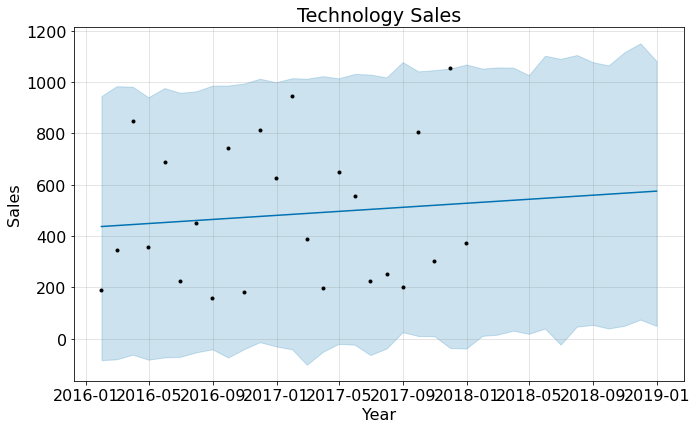

In [28]:
technology_sales_model.plot(technology_sales_forecast, xlabel = 'Year', ylabel = 'Sales')
plt.title('Technology Sales')
plt.show()

In [36]:
technology_sales['ds']

0    2016-01-31
1    2016-02-29
2    2016-03-31
3    2016-04-30
4    2016-05-31
5    2016-06-30
6    2016-07-31
7    2016-08-31
8    2016-09-30
9    2016-10-31
10   2016-11-30
11   2016-12-31
12   2017-01-31
13   2017-02-28
14   2017-03-31
15   2017-04-30
16   2017-05-31
17   2017-06-30
18   2017-07-31
19   2017-08-31
20   2017-09-30
21   2017-10-31
22   2017-11-30
23   2017-12-31
Name: ds, dtype: datetime64[ns]

In [37]:
from sklearn.metrics import mean_absolute_error
y_true = technology_sales['y'][-12:].values
y_pred = technology_sales_forecast['yhat'][-12:].values
mae = mean_absolute_error(y_true, y_pred)

In [42]:
mae

265.63527492895395

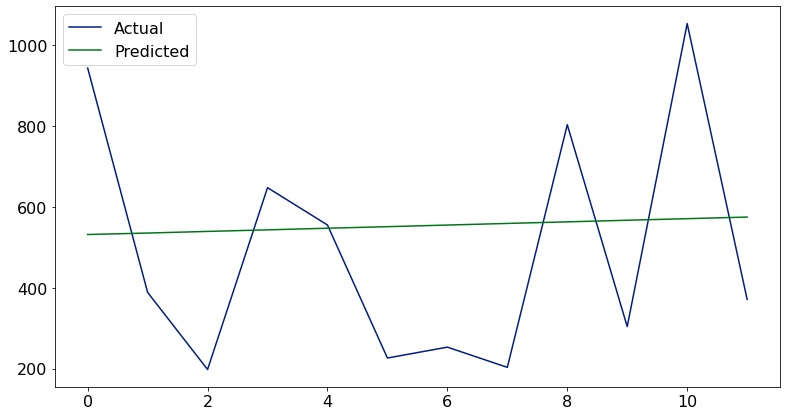

In [40]:
# plot expected vs actual
plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

In [ ]:
technology_profit_model.plot(technology_profit_forecast, xlabel = 'Year', ylabel = 'Profit')
plt.title('Technology Sales')
plt.show()

In [ ]:
technology_profit_forecast.head(1)

In [ ]:
technology_profit_forecast.tail(1)

In [ ]:
technology_model.plot(technology_forecast, xlabel = 'Year', ylabel = 'Sales')
plt.title('Technology Sales')
plt.show()

In [ ]:
office_model.plot(office_forecast, xlabel = 'Year', ylabel = 'Sales')
plt.title('Office Supplies Sales')
plt.show()

Its good to see that the category increasing overtime and keep growing.